In [1]:
import tensorflow
print(tensorflow.__version__)

E0000 00:00:1719633299.486286   12283 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="localhost"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0629 03:54:59.494656337   12283 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0629 03:54:59.494672370   12283 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0629 03:54:59.494675676   12283 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0629 03:54:59.494678039   12283 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0629 03:54:59.494680393   12283 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (

2.16.1


In [2]:
tpu = tensorflow.distribute.cluster_resolver.TPUClusterResolver('local')
print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
print('Running on TPU ', tpu.master())

tensorflow.config.experimental_connect_to_cluster(tpu)
tensorflow.tpu.experimental.initialize_tpu_system(tpu)
strategy = tensorflow.distribute.TPUStrategy(tpu)

# Should print REPLICAS = 8
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on a TPU w/8 cores
Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1719633305.578265   12283 service.cc:145] XLA service 0x5ba10529b230 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719633305.578326   12283 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1719633305.578330   12283 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1719633305.578333   12283 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1719633305.578336   12283 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1719633305.578339   12283 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1719633305.578341   12283 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1719633305.578344   12283 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1719633305.578347   12283 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
# tf.keras.mixed_precision.set_global_policy("mixed_bfloat16") # For TPU
# tf.keras.mixed_precision.set_global_policy('mixed_float16') # For GPU

In [3]:
# Import standard dependencies
import os
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import PIL
from sklearn.preprocessing import normalize # for normalizing np array to avoid NaN from dividing by 0
import glob

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization

In [4]:
num_classes = 85742
total_examples = 5822653

In [5]:
filenames = tensorflow.data.TFRecordDataset.list_files("/kaggle/input/faces-ms1m-refine-v2-112x112-tfrecord/faces_ms1m_refine_v2_112x112-*.tfrecord")
train_ds = tensorflow.data.TFRecordDataset(filenames, num_parallel_reads = tensorflow.data.AUTOTUNE)

# Raw_dataset contains serialized tf.train.Example messages, so we need to parse it.
# Create a description of the features.
feature_description = {'image_raw': tensorflow.io.FixedLenFeature([], tensorflow.string),
                        'label': tensorflow.io.FixedLenFeature([], tensorflow.int64)}

In [6]:
def parse_tfrecord_fn(example):
    example = tensorflow.io.parse_single_example(example, feature_description)
    img = tensorflow.io.decode_jpeg(example["image_raw"])
    img = tensorflow.reshape(img, shape=(112, 112, 3))
    img = tensorflow.cast(img, dtype=tensorflow.float32)
    # For EfficientNetV2, by default input preprocessing is included as a part of the model
    # (as a Rescaling layer)
    # img = img / 127.5 - 1.0     # Range is [-1, 1]
    label = tensorflow.cast(example['label'], dtype=tensorflow.int32)
    return img, label

In [7]:
train_ds = train_ds.map(parse_tfrecord_fn,num_parallel_calls = tensorflow.data.AUTOTUNE)

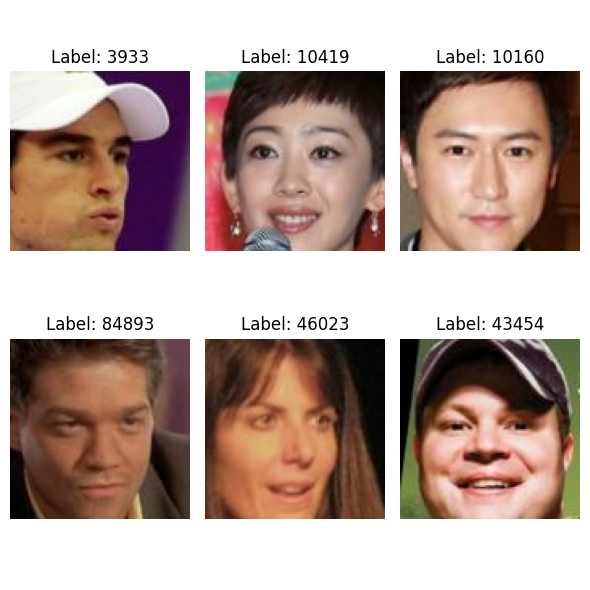

In [8]:
# Plotting first 6 examples

plt.figure(figsize=(6, 6))
plt.axis('off')
for idx, (image, label) in enumerate(train_ds.take(6)):

    ax = plt.subplot(2, 3, idx + 1)
    # Convert image from [-1, 1] range to [0, 1] for plt
    # image = (image + 1.0) / 2.0

    # Convert image from [0, 255] range to [0, 1] for plt
    image = image / 255.0

    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [9]:
"""
To train a model with the dataset pipeline you will want the data:
  To be well shuffled.
  To be batched.
  Batches to be available as soon as possible.
"""
batch_size_per_replica = 128
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
# global_batch_size = 256
steps_per_epoch = int( np.floor(total_examples/float(global_batch_size)) ) # floor as we will drop remind examples
train_ds = train_ds.repeat().batch(global_batch_size, drop_remainder = True).prefetch(buffer_size = tensorflow.data.AUTOTUNE)
# the training dataset must repeated equal to the number of epochs == train_ds.repeat(num_epochs)

In [10]:
def build_embedding():
    base_model = tensorflow.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(112, 112, 3))
#     base_model.trainable = False # Freeze the model

#     # Unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in base_model.layers[-20:]:
#         if not isinstance(layer, BatchNormalization):
#             layer.trainable = True

    avg_pool = GlobalAveragePooling2D(name="avg_pool")(base_model.output)  # Pass the output tensor of base_model to GlobalAveragePooling2D

    top_dropout_rate = 0.2
    top_dropout = Dropout(top_dropout_rate, name="top_dropout")(avg_pool)

    dense_512 = Dense(units=512, activation=None, name="pred")(top_dropout)  # No activation on the final dense layer == linear activation
    embedding = BatchNormalization(momentum=.99, epsilon=.001, scale=True, name="embedding")(dense_512)
    # build the embedding model and return it
    return Model(base_model.input, embedding, name="embedding")

In [11]:
class NormDense(tensorflow.keras.layers.Layer):
    def __init__(self, units=1000, **kwargs):
        super(NormDense, self).__init__(**kwargs)
        self.units = units
        # self.kernel_regularizer
    def build(self, input_shape):
            self.w = self.add_weight(
                name="norm_dense_w",
                shape=(input_shape[-1], self.units),
                initializer=tensorflow.keras.initializers.glorot_normal(), # glorot_uniform()
                trainable=True
            )

    def call(self, inputs, **kwargs):
        norm_w = tensorflow.nn.l2_normalize(self.w, axis=0, epsilon=1e-5) # each column is a weight vector
        norm_embedding = tensorflow.nn.l2_normalize(inputs, axis=1, epsilon=1e-5)
        cos_theta = tensorflow.linalg.matmul(norm_embedding, norm_w, name='cos_theta')
        return cos_theta

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [12]:
class ArcfaceLoss(tensorflow.keras.losses.Loss):
    def __init__(self, num_classes=85742, GLOBAL_BATCH_SIZE = 1024, margin1=1.0, margin2=0.5, margin3=0.0, scale=64.0, **kwargs):
        super(ArcfaceLoss, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.margin1, self.margin2, self.margin3, self.scale = margin1, margin2, margin3, scale
        #self.loss = tensorflow.keras.losses.categorical_crossentropy()
        # self.threshold = np.cos((np.pi - margin2) / margin1)  # grad(theta) == 0
        # self.theta_margin_min = (-1 - margin3) * 2
        self.loss_obj = tensorflow.keras.losses.CategoricalCrossentropy(reduction=tensorflow.keras.losses.Reduction.NONE, from_logits = True) # Linear activation input
        self.GLOBAL_BATCH_SIZE = GLOBAL_BATCH_SIZE
    def call(self, y_true, cos_theta):
        #one_hot = tensorflow.one_hot(tensorflow.squeeze(y_true, axis=-1), depth = self.num_classes)
        one_hot = tensorflow.one_hot(tensorflow.cast(y_true,tensorflow.int32), depth = self.num_classes)
        theta = tensorflow.math.acos(tensorflow.keras.backend.clip(cos_theta, -1.0 + tensorflow.keras.backend.epsilon(), 1.0 - tensorflow.keras.backend.epsilon()))
        target_logits = tensorflow.cos(theta * self.margin1 + self.margin2) - self.margin3
        logits = (cos_theta * (1.0 - one_hot) + target_logits * one_hot) * self.scale
        return tensorflow.nn.compute_average_loss(self.loss_obj(one_hot, logits), global_batch_size = self.GLOBAL_BATCH_SIZE)

    def get_config(self):
        config = super(ArcfaceLoss, self).get_config()
        config.update(
            {
                "margin1": self.margin1,
                "margin2": self.margin2,
                "margin3": self.margin3,
                "scale": self.scale
            }
        )
        return config

In [13]:
with strategy.scope():
    basic_model = build_embedding()
    inputs = basic_model.inputs[0] # Model may have multiple inputs
    embeddings = basic_model.outputs[0] # Model may have multiple outputs
    classification_output_layer = NormDense(units=num_classes)(embeddings)

    arcFaceModel = Model(inputs, classification_output_layer)
    opt = tensorflow.keras.optimizers.Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=0.1) # tfa.optimizers.SGDW(learning_rate=0.1, momentum=0.9, weight_decay=5e-5)
    arc_loss = ArcfaceLoss(num_classes = 85742)
    arcFaceModel.compile(optimizer = opt, loss = arc_loss) #, metrics = ["accuracy"]

I0000 00:00:1719633324.313204   12283 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [14]:
class eval_callback(tensorflow.keras.callbacks.Callback):
    def __init__(self, basic_model, test_path, GlobalBatchSize = 1024,flip=True):
        super(eval_callback, self).__init__()

        bins , issame = np.load(test_path, encoding="bytes", allow_pickle=True)
        self.test_names = os.path.splitext(os.path.basename(test_path))[0] #To save the name of the test set: LFW or agedb_30...
        self.ds = tensorflow.data.Dataset.from_tensor_slices(bins).map(lambda xx: tensorflow.cast(tensorflow.image.decode_image(xx, channels=3), dtype=tensorflow.float32))\
                       .batch(GlobalBatchSize)
        self.actual_issame = np.array(issame).astype("bool")

        self.basic_model = basic_model
        self.max_accuracy, self.best_acc, self.best_threshold = 0.0, 0.0, 0.0
        self.save_model = None # last eval dataset only will change this to save the model one time only
        self.flip = flip
        self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


    def __do_predict__(self):
        embs = []
        for img_batch in self.ds:
            emb = self.basic_model(img_batch, training=False)
            if self.flip:
                emb_f = self.basic_model(tensorflow.image.flip_left_right(img_batch))
                emb = emb + emb_f
            embs.extend(np.array(emb)) # adding embeddings to the current embeddings list while maintaining correct dimensions
        return np.array(embs)


    def __eval_func__(self, cur_epoch=0, logs=None):
        # print("self.model.params:", self.model.params if self.model else "None")
        cur_epoch = str(cur_epoch + 1)
        dists = []
        tensorflow.print("")
        embs = self.__do_predict__()

        if not np.alltrue(np.isfinite(embs)): # isfinite will return a matrix of booleans. False if the element is infinite
            tensorflow.print("NAN in embs, not a good one")
            return

#         ############ For Cosine Similarity
#         embs = normalize(embs) # We normalize the embeddnigs so that the dot product between each 2 images will represent the cosine
#         embs1 = embs[::2]  # will take even indices
#         embs2 = embs[1::2] # will take odd indices
#         dists = (embs_a * embs_b).sum(1) # axis=1. summing the rows after multiplying each element in image 1 with the crossponding in image 2
#                                         #=> dot product


        ########### For Euclidian distance
        embs = normalize(embs)
        embs1 = embs[::2]  # will take even indices
        embs2 = embs[1::2] # will take odd indices
        diff = np.subtract(embs1, embs2)
        dist = np.sum(np.square(diff), 1)

        self.best_threshold = -1
        self.best_acc = 0
        for threshold in np.arange(0, 2.0000111, 0.01): # for cosine: np.arange(-1, 1.0000111, 0.01)
            # predict_issame = np.greater(dist, threshold) # greater for cosine similarity
            predict_issame = np.less(dist, threshold) # less for euclidian distance,
            tp = np.sum(np.logical_and(predict_issame, self.actual_issame))
#             fp = np.sum(np.logical_and(predict_issame, np.logical_not(self.actual_issame)))
            tn = np.sum(np.logical_and(np.logical_not(predict_issame),
                                       np.logical_not(self.actual_issame)))
#             fn = np.sum(np.logical_and(np.logical_not(predict_issame), self.actual_issame))

#             tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
#             fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
            cur_acc = float(tp + tn) / dist.size
            if cur_acc>self.best_acc:
                self.best_acc = cur_acc
                self.best_threshold = threshold



        tensorflow.print(
            "\n>>>> %s evaluation max accuracy: %f, thresh: %f, previous max accuracy: %f" % (self.test_names, self.best_acc, self.best_threshold, self.max_accuracy)
        )

        if self.best_acc >= self.max_accuracy: #saving the model if we have improving in accuracy
            tensorflow.print(">>>> Improved = %f" % (self.best_acc - self.max_accuracy))
            self.max_accuracy = self.best_acc
            if self.save_model:
                save_name_base = "%s_basic_%s_epoch_" % (self.save_model, self.test_names)
                save_path_base = os.path.join("checkpoints", save_name_base)
                for ii in glob.glob(save_path_base + "*.h5"):
                    os.remove(ii)
                save_path = save_path_base + "%s_%f.h5" % (cur_epoch, self.max_accuracy)
                tensorflow.print("Saving model to: %s" % (save_path))
                self.basic_model.save(save_path, include_optimizer=False) # mostly the model won't be trained again so include_optimizer is false

In [15]:
class ExitOnNaN(tensorflow.keras.callbacks.Callback):
    """Callback that exit directly when a NaN loss is encountered, avoiding saving model"""

    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get("loss")
        if loss is not None:
            if not tensorflow.math.is_finite(loss):
                print("\nError: Invalid loss, terminating training")
                self.model.stop_training = True

In [16]:
class My_history(tensorflow.keras.callbacks.Callback):
    def __init__(self, evals=[]):
        super(My_history, self).__init__()

        self.history = {}
        self.evals = evals # list of objects where each object is a callback for certain test set
        self.custom_obj = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        """
        logs.pop("lr", None)
        lr = self.model.optimizer.lr
        if hasattr(lr, "value"):
            lr = lr.value()

        self.history.setdefault("lr", []).append(float(lr)) # setdefault if it didn't find lr key it will put its initial value []
        """
        for k, v in logs.items():
            self.history.setdefault(k, []).append(float(v))
        for evalOfOneDataSet in self.evals:
            self.history.setdefault(evalOfOneDataSet.test_names, []).append(float(evalOfOneDataSet.best_acc))
            self.history.setdefault(evalOfOneDataSet.test_names + "_thresh", []).append(float(evalOfOneDataSet.best_threshold))
        if len(self.model.losses) != 0:
            regularization_loss  = tensorflow.keras.backend.sum(self.model.losses).numpy() # loss due to using regularization
            self.history.setdefault("regular_loss", []).append(float(regularization_loss ))
            self.history["loss"][-1] -= regularization_loss # loss without regularization loss


    def print_hist(self):
        print("{")
        for k, v in self.history.items():
            print("  '%s': %s," % (k, v))
        print("}")

In [17]:
eval_paths = ['/kaggle/input/faces-ms1m-refine-v2-112x112-tfrecord/lfw.bin']#, '/kaggle/working/AgeDB/agedb_30.bin', '/kaggle/working/cfp_align_112/cfp_fp.bin']

my_evals = [eval_callback(basic_model, path, 1024 * strategy.num_replicas_in_sync) for path in eval_paths]

In [18]:
save_path = 'chekpoints'
"""
if len(my_evals) != 0: # last eval dataset only will change this to save the model one time only
    my_evals[-1].save_model = save_path
"""
my_history = My_history(my_evals)

callbacks = [my_evals, my_history, ExitOnNaN()]

In [19]:
arcFaceModel.fit(
            train_ds,
            epochs=30,
            callbacks=callbacks,
            steps_per_epoch=steps_per_epoch)  #num of batches

Epoch 1/30


2024-06-29 03:56:55.410481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1719633417.924496   13035 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(5214257d8ba60996:0:0), session_name()
I0000 00:00:1719633441.094601   13035 tpu_compile_op_common.cc:245] Compilation of 5214257d8ba60996:0:0 with session name  took 23.170044926s and succeeded
I0000 00:00:1719633441.177644   13035 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(5214257d8ba60996:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4648171187944919090", property.function_library_fingerprint = 15558229740265519941, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z 

5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 5.5043

>>>> lfw evaluation max accuracy: 0.933167, thresh: 1.620000, previous max accuracy: 0.000000
>>>> Improved = 0.933167
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 869s 133ms/step - loss: 5.5043
Epoch 2/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:46 114ms/step - loss: 4.6390

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.4874

>>>> lfw evaluation max accuracy: 0.963833, thresh: 1.530000, previous max accuracy: 0.933167
>>>> Improved = 0.030667
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 753s 132ms/step - loss: 4.4874
Epoch 3/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:29 111ms/step - loss: 3.7928

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 3.7010

>>>> lfw evaluation max accuracy: 0.975833, thresh: 1.500000, previous max accuracy: 0.963833
>>>> Improved = 0.012000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 759s 134ms/step - loss: 3.7010
Epoch 4/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:55 105ms/step - loss: 3.1650

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 3.1406

>>>> lfw evaluation max accuracy: 0.978833, thresh: 1.450000, previous max accuracy: 0.975833
>>>> Improved = 0.003000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 3.1406
Epoch 5/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:30 100ms/step - loss: 2.8388

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.7532

>>>> lfw evaluation max accuracy: 0.981833, thresh: 1.450000, previous max accuracy: 0.978833
>>>> Improved = 0.003000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 2.7532
Epoch 6/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:21 109ms/step - loss: 2.5515

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.4908

>>>> lfw evaluation max accuracy: 0.983500, thresh: 1.400000, previous max accuracy: 0.981833
>>>> Improved = 0.001667
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 764s 134ms/step - loss: 2.4908
Epoch 7/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:14 108ms/step - loss: 2.6163

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.3046

>>>> lfw evaluation max accuracy: 0.986833, thresh: 1.410000, previous max accuracy: 0.983500
>>>> Improved = 0.003333
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 767s 135ms/step - loss: 2.3046
Epoch 8/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:53 104ms/step - loss: 2.2151

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.1694

>>>> lfw evaluation max accuracy: 0.987000, thresh: 1.410000, previous max accuracy: 0.986833
>>>> Improved = 0.000167
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 2.1694
Epoch 9/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:43 113ms/step - loss: 2.1757

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.0716

>>>> lfw evaluation max accuracy: 0.988167, thresh: 1.390000, previous max accuracy: 0.987000
>>>> Improved = 0.001167
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 762s 134ms/step - loss: 2.0716
Epoch 10/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 11:25 121ms/step - loss: 1.9067

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5645/5686 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 1.9868
>>>> lfw evaluation max accuracy: 0.988667, thresh: 1.360000, previous max accuracy: 0.988167
>>>> Improved = 0.000500
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 766s 135ms/step - loss: 1.9867
Epoch 11/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:45 114ms/step - loss: 1.9229

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.9185

>>>> lfw evaluation max accuracy: 0.989000, thresh: 1.400000, previous max accuracy: 0.988667
>>>> Improved = 0.000333
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 763s 134ms/step - loss: 1.9185
Epoch 12/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:18 98ms/step - loss: 1.9648

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.8658

>>>> lfw evaluation max accuracy: 0.989667, thresh: 1.370000, previous max accuracy: 0.989000
>>>> Improved = 0.000667
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 762s 134ms/step - loss: 1.8658
Epoch 13/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:38 102ms/step - loss: 1.7775

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.8103

>>>> lfw evaluation max accuracy: 0.990833, thresh: 1.400000, previous max accuracy: 0.989667
>>>> Improved = 0.001167
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 763s 134ms/step - loss: 1.8103
Epoch 14/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 11:15 119ms/step - loss: 1.8813

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.7674

>>>> lfw evaluation max accuracy: 0.991167, thresh: 1.400000, previous max accuracy: 0.990833
>>>> Improved = 0.000333
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 764s 134ms/step - loss: 1.7674
Epoch 15/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:33 111ms/step - loss: 1.9342

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.7285

>>>> lfw evaluation max accuracy: 0.992000, thresh: 1.360000, previous max accuracy: 0.991167
>>>> Improved = 0.000833
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 1.7285
Epoch 16/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:52 115ms/step - loss: 1.7458

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6881

>>>> lfw evaluation max accuracy: 0.991833, thresh: 1.400000, previous max accuracy: 0.992000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 1.6881
Epoch 17/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:16 108ms/step - loss: 1.7315

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6605

>>>> lfw evaluation max accuracy: 0.991667, thresh: 1.340000, previous max accuracy: 0.992000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 760s 134ms/step - loss: 1.6605
Epoch 18/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 11:16 119ms/step - loss: 1.6750

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6293

>>>> lfw evaluation max accuracy: 0.992167, thresh: 1.400000, previous max accuracy: 0.992000
>>>> Improved = 0.000167
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 763s 134ms/step - loss: 1.6293
Epoch 19/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:54 105ms/step - loss: 1.5959

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.6033

>>>> lfw evaluation max accuracy: 0.992667, thresh: 1.410000, previous max accuracy: 0.992167
>>>> Improved = 0.000500
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 761s 134ms/step - loss: 1.6033
Epoch 20/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 11:07 117ms/step - loss: 1.8346

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.5813

>>>> lfw evaluation max accuracy: 0.992667, thresh: 1.420000, previous max accuracy: 0.992667
>>>> Improved = 0.000000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 762s 134ms/step - loss: 1.5813
Epoch 21/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:21 109ms/step - loss: 1.5725

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.5550

>>>> lfw evaluation max accuracy: 0.992667, thresh: 1.410000, previous max accuracy: 0.992667
>>>> Improved = 0.000000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 767s 135ms/step - loss: 1.5550
Epoch 22/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:55 115ms/step - loss: 1.5821

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.5353

>>>> lfw evaluation max accuracy: 0.992667, thresh: 1.360000, previous max accuracy: 0.992667
>>>> Improved = 0.000000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 761s 134ms/step - loss: 1.5353
Epoch 23/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:48 104ms/step - loss: 1.5420

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.5164

>>>> lfw evaluation max accuracy: 0.993167, thresh: 1.410000, previous max accuracy: 0.992667
>>>> Improved = 0.000500
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 763s 134ms/step - loss: 1.5164
Epoch 24/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:29 111ms/step - loss: 1.2992

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.4967

>>>> lfw evaluation max accuracy: 0.992833, thresh: 1.390000, previous max accuracy: 0.993167
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 134ms/step - loss: 1.4967
Epoch 25/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:40 113ms/step - loss: 1.4504

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.4818

>>>> lfw evaluation max accuracy: 0.993167, thresh: 1.390000, previous max accuracy: 0.993167
>>>> Improved = 0.000000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 759s 133ms/step - loss: 1.4818
Epoch 26/30


/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.4634

>>>> lfw evaluation max accuracy: 0.993500, thresh: 1.390000, previous max accuracy: 0.993167
>>>> Improved = 0.000333
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 763s 134ms/step - loss: 1.4634
Epoch 27/30


/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.4452

>>>> lfw evaluation max accuracy: 0.993500, thresh: 1.400000, previous max accuracy: 0.993500
>>>> Improved = 0.000000
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 762s 134ms/step - loss: 1.4452
Epoch 28/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:35 101ms/step - loss: 1.3364

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.4339

>>>> lfw evaluation max accuracy: 0.993333, thresh: 1.360000, previous max accuracy: 0.993500
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 1.4339
Epoch 29/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 10:42 113ms/step - loss: 1.3951

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.4147

>>>> lfw evaluation max accuracy: 0.993333, thresh: 1.370000, previous max accuracy: 0.993500
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 765s 135ms/step - loss: 1.4147
Epoch 30/30
   1/5686 ━━━━━━━━━━━━━━━━━━━━ 9:44 103ms/step - loss: 1.4738

/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


5686/5686 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.4010

>>>> lfw evaluation max accuracy: 0.993333, thresh: 1.390000, previous max accuracy: 0.993500
5686/5686 ━━━━━━━━━━━━━━━━━━━━ 764s 134ms/step - loss: 1.4010


/tmp/ipykernel_12283/1613290320.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)


In [20]:
print(">>>> Train %s DONE!!! epochs = %s, model.stop_training = %s" % (type, arcFaceModel.history.epoch, arcFaceModel.stop_training))
print(">>>> My history:")
my_history.print_hist()
latest_save_path = os.path.join(save_path + "_basic_model_latest.h5")
print(">>>> Saving latest basic model to:", latest_save_path)
basic_model.save(latest_save_path)

>>>> Train <class 'type'> DONE!!! epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], model.stop_training = False
>>>> My history:
{
  'loss': [5.242517948150635, 4.272149085998535, 3.545542001724243, 3.031780242919922, 2.6836130619049072, 2.440418004989624, 2.270230770111084, 2.142244815826416, 2.0482869148254395, 1.969901442527771, 1.9068387746810913, 1.8512775897979736, 1.7981643676757812, 1.7569621801376343, 1.7183208465576172, 1.6835585832595825, 1.6530725955963135, 1.625187873840332, 1.597482442855835, 1.5732547044754028, 1.5507524013519287, 1.5320457220077515, 1.51298987865448, 1.49228835105896, 1.4769606590270996, 1.4597172737121582, 1.4443004131317139, 1.428873896598816, 1.4120090007781982, 1.398812174797058],
  'lfw': [0.9331666666666667, 0.9638333333333333, 0.9758333333333333, 0.9788333333333333, 0.9818333333333333, 0.9835, 0.9868333333333333, 0.987, 0.9881666666666666, 0.9886666666666667, 0.989, 0.98966666

NameError: name 'save_path' is not defined